# **Apple Leaves Disease Classification**
---

![alt text](https://static.vikaspedia.in/media/images_en/agriculture/crop-production/integrated-pest-managment/ipm-for-fruit-crops/ipm-strategies-for-apple/Marssoninaleafblotch.jpg)


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# Upload The Dataset

Initializing a few parameters required for the image dataset preprocessing.

In [ ]:
import os
# Dimension of resized image
DEFAULT_IMAGE_SIZE = tuple((256, 256))
# Number of images used to train the model
N_IMAGES = 100

# Path to the dataset folder
root='/content/gdrive/MyDrive/Apple'
train_dir = os.path.join(root, 'train')
val_dir = os.path.join(root, 'val')

We use the function `convert_image_to_array` to resize an image to the size `DEFAULT_IMAGE_SIZE` we defined above.

In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)   
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

Here, we load the training data images by traversing through all the folders and converting all the images and labels into separate lists respectively.

*NOTE: We use a small portion of the entire dataset due to the computing limitations. Tweak `N_IMAGES` to include entire dataset.*

In [ ]:
import numpy as np
from os import listdir
import cv2
from keras.preprocessing.image import img_to_array
image_list, label_list = [], []

try:
    print("[INFO] Loading images ...")
    plant_disease_folder_list = listdir(train_dir)

    for plant_disease_folder in plant_disease_folder_list:
        print(f"[INFO] Processing {plant_disease_folder} ...")
        plant_disease_image_list = listdir(f"{train_dir}/{plant_disease_folder}/")

        for image in plant_disease_image_list[:N_IMAGES]:
            image_directory = f"{train_dir}/{plant_disease_folder}/{image}"
            if image_directory.endswith(".jpg")==True or image_directory.endswith(".JPG")==True:
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(plant_disease_folder)

    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

# Transform the loaded training image data into numpy array
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print()

# Check the number of images loaded for training
image_len = len(image_list)
print(f"Total number of images: {image_len}")

[INFO] Loading images ...
[INFO] Processing Apple___healthy ...
[INFO] Processing Apple___Cedar_apple_rust ...
[INFO] Processing Apple___Apple_scab ...
[INFO] Processing Apple___Black_rot ...
[INFO] Image loading completed

Total number of images: 400


Examine the labels/classes in the training dataset.

In [ ]:
from sklearn.preprocessing import LabelBinarizer
import pickle
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)

pickle.dump(label_binarizer,open('plant_disease_label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)
print("Total number of classes: ", n_classes)

Total number of classes:  4


# Augment and Split Dataset

Using `ImageDataGenerator` to augment data by performing various operations on the training images.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
augment = ImageDataGenerator(rotation_range=90, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode="nearest")

Splitting the data into training and test sets for validation purpose.

In [ ]:
from sklearn.model_selection import train_test_split
print("[INFO] Splitting data to train and test...")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

[INFO] Splitting data to train and test...


# Build Model

Defining the hyperparameters of the plant disease classification model.

In [ ]:
EPOCHS = 23
STEPS = 100
LR = 0.00001
BATCH_SIZE = 12
WIDTH = 256
HEIGHT = 256
DEPTH = 3

Creating a sequential model and adding Convolutional, Normalization, Pooling, Dropout and Activation layers at the appropriate positions.

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
model = Sequential()
inputShape = (HEIGHT, WIDTH, DEPTH)
chanDim = -1

if K.image_data_format() == "channels_first":
    inputShape = (DEPTH, HEIGHT, WIDTH)
    chanDim = 1

model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(BatchNormalization(axis=chanDim))
# model.add(Conv2D(128, (3, 3), padding="same"))
# model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))


model.add(Flatten())



model.add(Dense(256,kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.02,l2=0.02)))
model.add(Activation("relu"))
model.add(Dropout(0.2))
model.add(Dense(256,kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.02,l2=0.02)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(128,kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.02,l2=0.02)))
model.add(Activation('relu'))


model.add(Dense(n_classes))
model.add(Activation("softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
activation_8 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
activation_9 (Activation)    (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 32)       

# Train Model

We initialize Adam optimizer with learning rate and decay parameters. 

Also, we choose the type of loss and metrics for the model and compile it for training.

In [ ]:
from keras.optimizers import Adam
# Initialize optimizer
opt = Adam(learning_rate=LR)

# Compile model
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train model
print("[INFO] Training network...")
history = model.fit_generator(augment.flow(x_train, y_train, batch_size=BATCH_SIZE), validation_data=(x_test, y_test), steps_per_epoch=len(x_train) // BATCH_SIZE, epochs=EPOCHS, verbose=1)

[INFO] Training network...


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/23
26/26 [==============================] - 7s 199ms/step - loss: 2361.6548 - accuracy: 0.2624 - val_loss: 2246.7910 - val_accuracy: 0.2500
Epoch 2/23
26/26 [==============================] - 4s 163ms/step - loss: 2209.2930 - accuracy: 0.4313 - val_loss: 2098.4202 - val_accuracy: 0.2250
Epoch 3/23
26/26 [==============================] - 4s 163ms/step - loss: 2061.5254 - accuracy: 0.4361 - val_loss: 1954.9508 - val_accuracy: 0.2875
Epoch 4/23
26/26 [==============================] - 4s 164ms/step - loss: 1919.6212 - accuracy: 0.5864 - val_loss: 1816.4216 - val_accuracy: 0.3250
Epoch 5/23
26/26 [==============================] - 4s 164ms/step - loss: 1782.5592 - accuracy: 0.5938 - val_loss: 1682.9672 - val_accuracy: 0.2375
Epoch 6/23
26/26 [==============================] - 4s 165ms/step - loss: 1650.2678 - accuracy: 0.6291 - val_loss: 1554.6699 - val_accuracy: 0.3375
Epoch 7/23
26/26 [==============================] - 4s 166ms/step - loss: 1522.9987 - accuracy: 0.6325 - val_los

# Evaluate Model

Comparing the accuracy and loss by plotting the graph for training and validation.

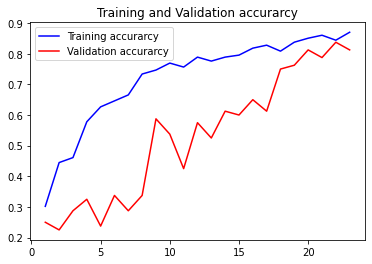

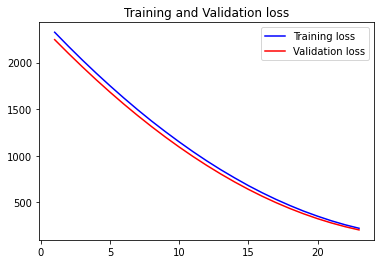

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()

# Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

Evaluating model accuracy by using the `evaluate` method

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
3/3 [==============================] - 0s 22ms/step - loss: 203.9585 - accuracy: 0.8125
Test Accuracy: 81.25


# Save Model

In [ ]:
# Dump pickle file of the model
print("[INFO] Saving model...")
with open('plant_disease_classification_model.pkl', 'wb') as file:
    pickle.dump(test, file)
# pickle.dump(model,open('plant_disease_classification_model.pkl', 'wb'))

[INFO] Saving model...


In [ ]:
# Dump pickle file of the labels
print("[INFO] Saving label transform...")
filename = 'plant_disease_label_transform.pkl'
image_labels = pickle.load(open(filename, 'rb'))

[INFO] Saving label transform...


# Test Model

We write the following `predict_disease` function to predict the class or disease of a plant image. 

We just need to provide the complete path to the image and it displays the image along with its prediction class or plant disease.

In [ ]:
def predict_disease(image_path):
    image_array = convert_image_to_array(image_path)
    np_image = np.array(image_array, dtype=np.float16) / 225.0
    np_image = np.expand_dims(np_image,0)
    plt.imshow(plt.imread(image_path))
    result = model.predict_classes(np_image)
    print((image_labels.classes_[result][0]))

For testing purposes, we randomly choose images from the dataset and try predicting class or disease of the plant image.

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Apple___Apple_scab


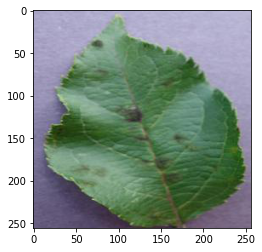

In [ ]:
predict_disease('/content/gdrive/MyDrive/Apple/val/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG')

Apple___Black_rot


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


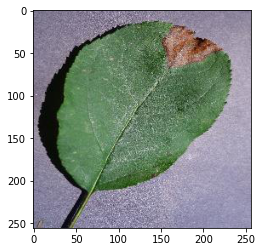

In [ ]:
predict_disease('/content/gdrive/MyDrive/Apple/val/Apple___Black_rot/0139bc6d-391c-4fd1-bcae-cc74dabfddd7___JR_FrgE.S 2734.JPG')

Apple___Cedar_apple_rust


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


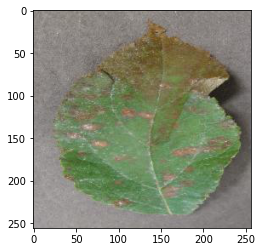

In [ ]:
predict_disease('/content/gdrive/MyDrive/Apple/val/Apple___Cedar_apple_rust/1e099d8e-b40c-4cf3-bb52-4e77b5a2dc69___FREC_C.Rust 0155.JPG')

Apple___healthy


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


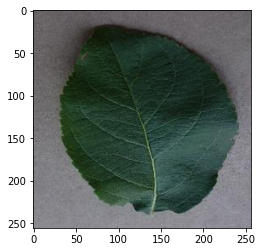

In [ ]:
predict_disease('/content/gdrive/MyDrive/Apple/val/Apple___healthy/0872ffc6-d9db-4ba7-a2bf-1fb0f537cafb___RS_HL 6129.JPG')

# Reuse Model

Download the trained model and label transform saved in the Google Drive.

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Import all the necessary libraries

In [ ]:
import os
import numpy as np
from os import listdir
import cv2
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
import pickle
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.optimizers import Adam
import matplotlib.pyplot as plt

Load the trained model and its labels for prediction.

In [ ]:
# Load model
filename = '/content/gdrive/MyDrive/plant_disease_classification_model.pkl'
model = pickle.load(open(filename, 'rb'))

# Load labels
filename = '/content/gdrive/MyDrive/plant_disease_label_transform.pkl'
image_labels = pickle.load(open(filename, 'rb'))

We use the `convert_image_to_array` function to resize an image and `predict_disease` function to predict the class or disease of a plant image.

We just need to provide the complete path to the image and it displays the image along with its prediction class or plant disease.

In [ ]:
DEFAULT_IMAGE_SIZE = tuple((256, 256))

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)   
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

def predict_disease(image_path):
    image_array = convert_image_to_array(image_path)
    np_image = np.array(image_array, dtype=np.float16) / 225.0
    np_image = np.expand_dims(np_image,0)
    plt.imshow(plt.imread(image_path))
    result = model.predict_classes(np_image)
    print((image_labels.classes_[result][0]))

Predict disease of any plant image

AttributeError: ignored

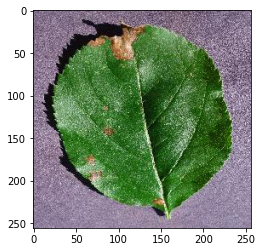

In [ ]:
predict_disease('/content/gdrive/MyDrive/Apple/val/Apple___Black_rot/723e8edc-3701-4ba1-bda2-7e0ebd535797___JR_FrgE.S 2837.JPG')